In [ ]:
# import langgraph
from langgraph.graph import StateGraph, START, END
# from langchain_openai import ChatOpenAI
from tavily import TavilyClient
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict
import os
from langchain.chat_models import init_chat_model

os.environ['TAVILY_API_KEY'] = "tvly-"
os.environ['GROQ_API_KEY'] = "gsk_"

model = init_chat_model("qwen-2.5-32b", model_provider="groq", temperature=0.05)

# Define the state for the graph
class BlogState(TypedDict):
    query: str
    outline: str
    blog: str
    enhanced_query: str
    web_results: str
    refined_web_results: str

# Initialize OpenAI model
# model = ChatOpenAI(model="gpt-4-turbo", temperature=0.7)
# @timeit_node
def enhance_search_query(state: BlogState) -> dict:
    """Generates a refined search query to get relevant results."""
    prompt = f"""
    You are an expert in information retrieval. Given the blog topic: "{state['query']}", 
    generate a refined search query that will provide the most relevant, up-to-date information.
    Example:
    - User Query: "Write a blog on GPT working"
    - Refined Search Query: "How does GPT work? Latest advancements in transformer models"
    Now generate a similar refined search query for: "{state['query']}".
    STrictly provide only the enhanced query without any explanation at all.
    """
    response = model.invoke([HumanMessage(content=prompt)])
    return {"enhanced_query": response.content.strip()}

# @timeit_node
def web_search(state: BlogState) -> dict:
    """Fetches real-time information using Tavily search API."""

    api_key = os.getenv("TAVILY_API_KEY")
    tavily_client = TavilyClient(api_key=api_key)
    response = tavily_client.search(
        state['enhanced_query'].strip('"').strip(),
        days=30,
        max_results=5,
        search_depth="advanced"
    )

    formatted_results = "\n\n".join(
        f"Title: {result['title']}\nContent: {result['content']}"
        for result in response["results"]
    )
    return {"web_results": formatted_results}

# @timeit_node
def refine_web_results(state: BlogState) -> dict:
    """
    Processes the raw web search results along with the enhanced query,
    and returns a refined, structured version of the information.
    """
    prompt = f"""
    You are an expert data curator. Given the enhanced search query: "{state['enhanced_query']}" 
    and the following raw web search results: "{state['web_results']}", 
    extract and format only the most relevant and useful information that directly pertains to the search query.
    Provide only the refined output without any explanation. Do not hallucinate.
    """
    response = model.invoke([HumanMessage(content=prompt)])
    return {"refined_web_results": response.content.strip()}

# @timeit_node
def generate_blog_outline(state: BlogState) -> dict:
    """Generates a blog outline based on the user query and the refined web results."""
    prompt = f"""
    You are a blog outline generator. Based on the query: "{state['query']}" and the following refined web search results: "{state['refined_web_results']}", 
    construct a professional blog outline that is engaging, informative, and well-structured.
    STrictly provide only the blog outline without any explanation at all.
    """
    response = model.invoke([HumanMessage(content=prompt)])
    return {"outline": response.content.strip()}

# @timeit_node
def generate_blog(state: BlogState) -> dict:
    """Generates a blog draft using the outline and refined web search data."""
    prompt = f"""
    Write a detailed blog post on the topic: "{state['query']}" based on the following outline: "{state['outline']}" 
    and incorporating the following refined real-time data: "{state['refined_web_results']}". 
    Ensure it's engaging, informative, and well-structured.
    """
    response = model.invoke([HumanMessage(content=prompt)])
    return {"blog": response.content.strip()}

# Create the graph
graph = StateGraph(BlogState)
graph.add_node("enhance_search_query", enhance_search_query)
graph.add_node("web_search", web_search)
graph.add_node("refine_web_results", refine_web_results)
graph.add_node("generate_blog_outline", generate_blog_outline)
graph.add_node("generate_blog", generate_blog)

# Define edges:
graph.add_edge(START, "enhance_search_query")
graph.add_edge("enhance_search_query", "web_search")
graph.add_edge("web_search", "refine_web_results")
graph.add_edge("refine_web_results", "generate_blog_outline")
# graph.add_edge("refine_web_results", "generate_blog")
graph.add_edge("generate_blog_outline", "generate_blog")
graph.add_edge("generate_blog", END)

# Compile the graph
graph = graph.compile()

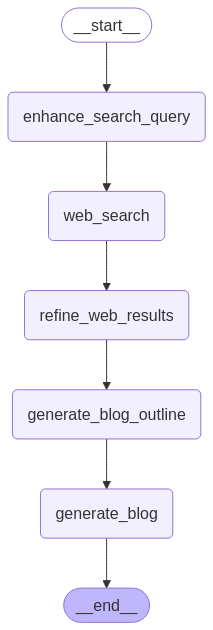

In [18]:
from IPython.display import Image, display, Markdown
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
from rich import print
query = "llama 4 model features and benchmarks"
initial_state = {"query":query}

for step in graph.stream(initial_state):
    print(step)

{'enhance_search_query': {'enhanced_query': '"LLaMA 4 model latest features and performance benchmarks 2023"'}}

{
    'web_search': {
        'web_results': "Title: GPT-4 Turbo vs Llama 4 Maverick - DocsBot AI\nContent: Llama 4 Maverick is 12 months
newer than GPT-4 Turbo. It has more recent training data (March 2025 vs December 2023). Llama 4 Maverick has a 
larger context window (1M vs 128K tokens). Unlike GPT-4 Turbo, Llama 4 Maverick supports video processing. [...] 
Llama 4 Maverick is a 17 billion active parameter model with 128 experts (400B total parameters), making it the 
best multimodal model in its class. It outperforms GPT-4o and Gemini 2.0 Flash across many benchmarks while 
achieving comparable results to DeepSeek v3 on reasoning and coding with less than half the active parameters. It 
offers best-in-class performance-to-cost ratio with an experimental chat version scoring ELO of 1417 on LMArena. 
Maverick fits on a single H100 host for easy [...] Knowledge Cut-off DateWhen the model's knowledge was last 
updated. | December 2023 | March 2025\nAPI ProvidersThe providers that offer this model. (This is not an exhaustive
list.) | OpenAI, Azure OpenAI Service | Meta AI, Hugging Face, Fireworks, Together, DeepInfra\nSupported 
ModalitiesThe types of inputs the model can process. |  |\n\nTitle: Llama 4 Models: Meta AI is Open Sourcing the 
Best - Analytics Vidhya\nContent: Meta has shared detailed benchmark results for all three Llama 4 models, 
reflecting how each performs based on its design goals and parameter sizes. They also outperform leading models in 
several newly introduced benchmarks that are particularly challenging and comprehensive.\nLlama 4 Scout\nScout, 
despite being the smallest in the family, performs remarkably well in efficiency-focused evaluations: [...] These 
benchmarks highlight how each model excels in its role: Scout delivers speed and efficiency, Maverick handles power
and general-purpose tasks, and Behemoth serves as a research-grade teacher model for distillation and 
evaluation.\nComparing the Llama 4 Models\nWhile all the three models come with their own features, here is a brief
summary that can help you find the right Llama 4 model for your task:\nModel\nTotal Params\nActive 
Params\nExperts\nContext Length\nRuns on\nPublic Access\nIdeal For [...] The Llama 4 Models: Scout, Maverick, and 
Behemoth\nLlama 4 Scout: Small, Fast, and Smart\nLlama 4 Maverick: Strong and Reliable\nLlama 4 Behemoth: The 
Teacher Model\n\n\nHow to Access the Llama 4 Models?\nLlama 4 Models: Let’s Try!\nTask 1: Creative Planning\nTask 
2: Coding\nTask 3: Image Generation\n\n\nTraining and Post-Training of Llama 4 Models\nPre-Training 
Phase\nPost-Training Phase\n\n\nMeta Llama 4 Benchmark Performance\nLlama 4 Scout\nLlama 4 Maverick\nLlama 4 
Behemoth\n\nTitle: Llama\nContent: LlamaCon\nSave the date for an exclusive event exploring the exciting 
possibilities and potential of Llama.\n4.29.25\nSign up\nLatest models\nLlama includes multilingual text-only 
models (1B, 3B), including quantized versions, text-image models (11B, 90B) and Llama 3.3 70B model offering 
similar performance to the Llama 3.1 405B model, allowing developers to achieve greater quality and performance on 
text-based applications at a fraction of the cost. \nStart building\nMultilingual\nLlama 3.1\n•\n\nTitle: The 
future of AI: Built with Llama - Meta AI\nContent: As Meta Founder & CEO Mark Zuckerberg shared, Llama has quickly 
become the most adopted model, with more than 650 million downloads of Llama and its derivatives, twice as many 
downloads as we had three months ago. Putting that in perspective, Llama models have now been downloaded an average
of one million times a day since our first release in February 2023. [...] Research\nMultiRay: Optimizing 
efficiency for large-scale AI models\nNovember 18, 2022\nRead post\nFEATURED\n\nML Applications\nMuAViC: The first 
audio-video speech translation benchmark\nMarch 8, 2023\nRead post\nOur approach\nAbout AI at 
Meta\nPeople\nCareers\nResearch\nInfrastructure\nResources\nDemos\nProduct experien

{
    'refine_web_results': {
        'refined_web_results': '- **Model Name**: Llama 4 Maverick\n- **Knowledge Cut-off Date**: March 2025\n- 
**Active Parameters**: 17 billion\n- **Experts**: 128\n- **Context Window**: 1M tokens\n- **Supported Modalities**:
Multimodal (text, image, video)\n- **Performance Benchmarks**: \n  - Outperforms GPT-4o and Gemini 2.0 Flash across
many benchmarks\n  - Achieves comparable results to DeepSeek v3 on reasoning and coding with less than half the 
active parameters\n  - Experimental chat version scores ELO of 1417 on LMArena\n- **Performance-to-Cost Ratio**: 
Best-in-class\n- **API Providers**: Meta AI, Hugging Face, Fireworks, Together, DeepInfra'
    }
}

{
    'generate_blog_outline': {
        'outline': "I. Introduction\n   A. Brief overview of AI models and their importance\n   B. Introduction to 
Llama 4 Maverick: A new frontier in AI technology\n\nII. Llama 4 Maverick: An Overview\n   A. Key Features\n      
1. Active Parameters: 17 billion\n      2. Knowledge Cut-off Date: March 2025\n      3. Experts: 128\n      4. 
Context Window: 1M tokens\n      5. Supported Modalities: Multimodal (text, image, video)\n   B. The Evolution of 
Llama Models\n\nIII. Performance Benchmarks\n   A. Comparative Analysis\n      1. Outperformance of GPT-4o and 
Gemini 2.0 Flash\n      2. Reasoning and Coding Capabilities: A Comparison with DeepSeek v3\n   B. Experimental 
Chat Version: ELO Score on LMArena\n\nIV. Performance-to-Cost Ratio\n   A. Understanding the Value Proposition\n   
B. Best-in-Class Performance-to-Cost Ratio: What It Means for Users\n\nV. Accessibility and Integration\n   A. API 
Providers: Meta AI, Hugging Face, Fireworks, Together, DeepInfra\n   B. How to Get Started with Llama 4 
Maverick\n\nVI. Conclusion\n   A. Recap of Llama 4 Maverick's Unique Selling Points\n   B. The Future of Llama 4 
Maverick: Potential and Possibilities\n\nVII. FAQs\n   A. What is the Knowledge Cut-off Date?\n   B. How does Llama
4 Maverick compare to other models in terms of cost?\n   C. What are the supported modalities, and how do they 
enhance user experience?\n   D. How can one access and use Llama 4 Maverick through API providers?"
    }
}

{
    'generate_blog': {
        'blog': "# Llama 4 Maverick: A Leap Forward in AI Technology\n\n## I. Introduction\n\n### A. Brief Overview
of AI Models and Their Importance\n\nArtificial Intelligence (AI) models have become the backbone of modern 
technological advancements, powering everything from virtual assistants to autonomous vehicles. These models are 
designed to process vast amounts of data, learn from it, and make decisions or predictions with human-like 
intelligence. The importance of AI models lies in their ability to automate complex tasks, enhance decision-making 
processes, and drive innovation across various industries.\n\n### B. Introduction to Llama 4 Maverick: A New 
Frontier in AI Technology\n\nIn the ever-evolving landscape of AI, Llama 4 Maverick emerges as a groundbreaking 
model that sets a new standard for performance and efficiency. This blog post delves into the features, benchmarks,
and implications of Llama 4 Maverick, offering insights into its capabilities and potential impact on the future of
AI.\n\n## II. Llama 4 Maverick: An Overview\n\n### A. Key Features\n\n- **Active Parameters**: 17 billion\n- 
**Knowledge Cut-off Date**: March 2025\n- **Experts**: 128\n- **Context Window**: 1M tokens\n- **Supported 
Modalities**: Multimodal (text, image, video)\n\nLlama 4 Maverick is equipped with 17 billion active parameters, 
making it a powerful tool for complex tasks. Its knowledge cut-off date is set for March 2025, ensuring that it is 
up-to-date with the latest information. The model supports 128 experts, enhancing its ability to handle specialized
tasks. With a context window of 1 million tokens, Llama 4 Maverick can process extensive data sets, making it ideal
for long-form content analysis and generation. Its multimodal capabilities allow it to handle text, images, and 
videos, providing a versatile solution for diverse applications.\n\n### B. The Evolution of Llama Models\n\nThe 
Llama series has been a trailblazer in the AI community, with each iteration building upon the strengths of its 
predecessors. Llama 4 Maverick represents the culmination of this evolution, offering significant improvements in 
performance, efficiency, and versatility.\n\n## III. Performance Benchmarks\n\n### A. Comparative Analysis\n\n- 
**Outperformance of GPT-4o and Gemini 2.0 Flash**: Llama 4 Maverick surpasses GPT-4o and Gemini 2.0 Flash in 
numerous benchmarks, showcasing its superior performance.\n- **Reasoning and Coding Capabilities**: When compared 
to DeepSeek v3, Llama 4 Maverick achieves comparable results in reasoning and coding tasks, despite having less 
than half the active parameters. This efficiency makes it a cost-effective solution for high-performance 
tasks.\n\n### B. Experimental Chat Version: ELO Score on LMArena\n\nThe experimental chat version of Llama 4 
Maverick has achieved an impressive ELO score of 1417 on LMArena, a platform for evaluating AI chatbot performance.
This score reflects the model's robust conversational abilities and its potential to revolutionize human-computer 
interaction.\n\n## IV. Performance-to-Cost Ratio\n\n### A. Understanding the Value Proposition\n\nThe 
performance-to-cost ratio is a critical metric for evaluating the efficiency and value of AI models. Llama 4 
Maverick stands out for its best-in-class performance-to-cost ratio, making it an attractive option for businesses 
and researchers looking to leverage advanced AI capabilities without breaking the bank.\n\n### B. Best-in-Class 
Performance-to-Cost Ratio: What It Means for Users\n\nFor users, this means access to cutting-edge AI technology at
a fraction of the cost of other high-performance models. Llama 4 Maverick's efficiency and cost-effectiveness make 
it a game-changer in the AI industry, offering unparalleled value and performance.\n\n## V. Accessibility and 
Integration\n\n### A. API Providers: Meta AI, Hugging Face, Fireworks, Together, DeepInfra\n\nLlama 4 Maverick is 
accessible through a vari

In [22]:
display(Markdown(step['generate_blog']['blog']))

# Llama 4 Maverick: A Leap Forward in AI Technology

## I. Introduction

### A. Brief Overview of AI Models and Their Importance

Artificial Intelligence (AI) models have become the backbone of modern technological advancements, powering everything from virtual assistants to autonomous vehicles. These models are designed to process vast amounts of data, learn from it, and make decisions or predictions with human-like intelligence. The importance of AI models lies in their ability to automate complex tasks, enhance decision-making processes, and drive innovation across various industries.

### B. Introduction to Llama 4 Maverick: A New Frontier in AI Technology

In the ever-evolving landscape of AI, Llama 4 Maverick emerges as a groundbreaking model that sets a new standard for performance and efficiency. This blog post delves into the features, benchmarks, and implications of Llama 4 Maverick, offering insights into its capabilities and potential impact on the future of AI.

## II. Llama 4 Maverick: An Overview

### A. Key Features

- **Active Parameters**: 17 billion
- **Knowledge Cut-off Date**: March 2025
- **Experts**: 128
- **Context Window**: 1M tokens
- **Supported Modalities**: Multimodal (text, image, video)

Llama 4 Maverick is equipped with 17 billion active parameters, making it a powerful tool for complex tasks. Its knowledge cut-off date is set for March 2025, ensuring that it is up-to-date with the latest information. The model supports 128 experts, enhancing its ability to handle specialized tasks. With a context window of 1 million tokens, Llama 4 Maverick can process extensive data sets, making it ideal for long-form content analysis and generation. Its multimodal capabilities allow it to handle text, images, and videos, providing a versatile solution for diverse applications.

### B. The Evolution of Llama Models

The Llama series has been a trailblazer in the AI community, with each iteration building upon the strengths of its predecessors. Llama 4 Maverick represents the culmination of this evolution, offering significant improvements in performance, efficiency, and versatility.

## III. Performance Benchmarks

### A. Comparative Analysis

- **Outperformance of GPT-4o and Gemini 2.0 Flash**: Llama 4 Maverick surpasses GPT-4o and Gemini 2.0 Flash in numerous benchmarks, showcasing its superior performance.
- **Reasoning and Coding Capabilities**: When compared to DeepSeek v3, Llama 4 Maverick achieves comparable results in reasoning and coding tasks, despite having less than half the active parameters. This efficiency makes it a cost-effective solution for high-performance tasks.

### B. Experimental Chat Version: ELO Score on LMArena

The experimental chat version of Llama 4 Maverick has achieved an impressive ELO score of 1417 on LMArena, a platform for evaluating AI chatbot performance. This score reflects the model's robust conversational abilities and its potential to revolutionize human-computer interaction.

## IV. Performance-to-Cost Ratio

### A. Understanding the Value Proposition

The performance-to-cost ratio is a critical metric for evaluating the efficiency and value of AI models. Llama 4 Maverick stands out for its best-in-class performance-to-cost ratio, making it an attractive option for businesses and researchers looking to leverage advanced AI capabilities without breaking the bank.

### B. Best-in-Class Performance-to-Cost Ratio: What It Means for Users

For users, this means access to cutting-edge AI technology at a fraction of the cost of other high-performance models. Llama 4 Maverick's efficiency and cost-effectiveness make it a game-changer in the AI industry, offering unparalleled value and performance.

## V. Accessibility and Integration

### A. API Providers: Meta AI, Hugging Face, Fireworks, Together, DeepInfra

Llama 4 Maverick is accessible through a variety of API providers, including Meta AI, Hugging Face, Fireworks, Together, and DeepInfra. This wide range of providers ensures that users can easily integrate Llama 4 Maverick into their existing systems and workflows.

### B. How to Get Started with Llama 4 Maverick

Getting started with Llama 4 Maverick is straightforward. Users can sign up with one of the API providers, integrate the model into their applications, and begin leveraging its advanced capabilities. Detailed documentation and community support are available to help users maximize the model's potential.

## VI. Conclusion

### A. Recap of Llama 4 Maverick's Unique Selling Points

Llama 4 Maverick is a powerful AI model with a unique combination of features, including a large context window, multimodal capabilities, and a best-in-class performance-to-cost ratio. Its ability to outperform leading models while maintaining efficiency makes it a standout choice for a wide range of applications.

### B. The Future of Llama 4 Maverick: Potential and Possibilities

The future of Llama 4 Maverick looks promising, with potential applications in fields such as natural language processing, image and video analysis, and more. As the model continues to evolve, it is poised to play a significant role in shaping the future of AI technology.

## VII. FAQs

### A. What is the Knowledge Cut-off Date?

The knowledge cut-off date for Llama 4 Maverick is March 2025, ensuring that the model is equipped with the latest information and knowledge up to that date.

### B. How Does Llama 4 Maverick Compare to Other Models in Terms of Cost?

Llama 4 Maverick offers a best-in-class performance-to-cost ratio, making it a cost-effective solution compared to other high-performance models in the market.

### C. What Are the Supported Modalities, and How Do They Enhance User Experience?

Llama 4 Maverick supports multimodal inputs, including text, images, and videos. This capability enhances user experience by allowing for more natural and comprehensive interactions with the model.

### D. How Can One Access and Use Llama 4 Maverick Through API Providers?

Users can access Llama 4 Maverick through API providers such as Meta AI, Hugging Face, Fireworks, Together, and DeepInfra. Detailed documentation and community support are available to help users integrate and utilize the model effectively.

Llama 4 Maverick is not just an AI model; it's a leap forward in AI technology, promising to transform how we interact with and utilize AI in our daily lives and professional environments.